In [16]:
import numpy as np
import matplotlib.pyplot as plt
import os
import matplotlib as mpl
import matplotlib.cm as cm
import cPickle as pickle
import helpers
import plots
import pandas as pd
import glob
import plot_ts
import fwd_likelihoods as fl
reload(plots)
reload(helpers)

<module 'helpers' from 'helpers.pyc'>

In [20]:
print 'Loading posterior mean dataframe'
df = pickle.load(open('pm_df.p', 'rb'))

print 'Loading posterior sample dictionary'
data_dict = pickle.load(open('indiv_dict.p', 'rb'))

print 'Loading group sample dictionary'
group_dict = pickle.load(open('group_dict.p', 'rb'))

Loading posterior mean dataframe
Loading posterior sample dictionary
Loading group sample dictionary


In [49]:
def plot_IMI(data_dir, data_dict, cutoff=300, num_samples=10):
    windowsize = 5
    err_thresh = 20000
    
    p_lengths = []
    g_ends = []
    c = []

    ## Assemble dataset
    count = len(os.listdir(data_dir))
    for i, dataset in enumerate(os.listdir(data_dir)):
        data = np.loadtxt(data_dir+dataset, delimiter='\t', usecols=(0,1,2,3,4))

        for j in data:
            f_lengths, g_starts, rates, p_length, g_end = j

            if p_length > cutoff and p_length < err_thresh:
                p_lengths.append(p_length)
                g_ends.append(g_end)
                c.append(float(i)/count)

            if p_length > err_thresh:
                print 'Error in %s, IMI of %3.0f' %(dataset, p_length)

    ## Process to use in moving window
    results = zip(g_ends, p_lengths)
    results = np.array(results)

    ## Generate moving window mean
    x_grid = np.linspace(0, np.max(results[:,0]), 100)

    means = []
    for xval in x_grid:
        usevals = np.abs(results[:,0] - xval) < windowsize
        meanval = np.mean(results[usevals, 1])
        means.append(meanval)

    """
    for i in results:
        print '%3.3f\t%3.3f' %(i[0], i[1])
    """
    means = np.array(means)

    ## Plot moving window
    fig, axes = plt.subplots(1)
    axes.scatter(results[:,0], 
                 results[:,1], 
                 alpha=0.3, 
                 c='b', # use c=c to get individual colour coding
                 cmap=cm.gist_ncar)
    
    axes.plot(x_grid, means, c='k')
    
    ## Generate posterior predictive curve
    post = data_dict[data_dir.split('/')[1]+'_trace.p']
    post = np.mean(post, axis=0)
    
    mean_ppcs = []
    ppcs_low = []
    ppcs_high = []
    k1 = 0.00055
    sample_x_grid = np.linspace(0, np.max(results[:,0]), 30)
    for xval in sample_x_grid:
        samples = []
        for i in range(num_samples):
            theta7 = np.power(10., post[6])
            theta8 = np.power(10., post[7])
            samples.append(fl.sample_L(xval, k1, theta7, theta8))
            
        mean_ppcs.append(np.mean(samples))
        ppc_low = np.percentile(samples, 5)
        ppc_high = np.percentile(samples, 95)
        ppcs_low.append(ppc_low)
        ppcs_high.append(ppc_high)
        
    axes.plot(sample_x_grid, mean_ppcs, c='r')
    axes.fill_between(sample_x_grid, ppcs_low, ppcs_high, color='r', alpha=0.3)
    
    plt.show()

vehicle_0.0_A_D
LiCl_32.0_A_D
PYY_7.5_A_D
GLP-1_300.0_A_D
PYY_300.0_A_D
sib_0.9_A_D
saline_0.0_R_L
Error in saline_0.0_R_L_4_10_2015-11-23.B0104.CSV, IMI of 20587


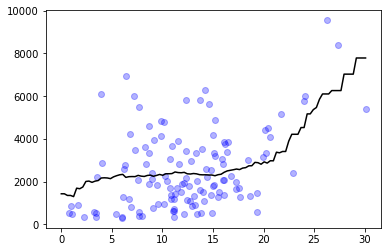

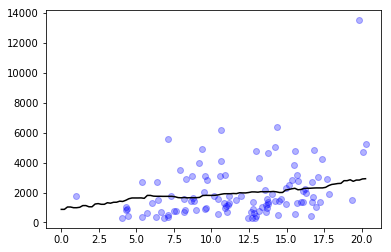

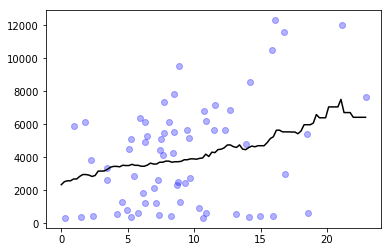

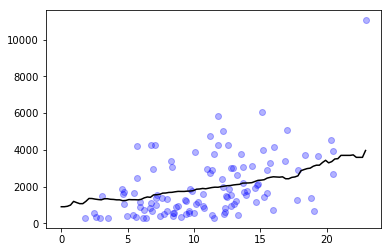

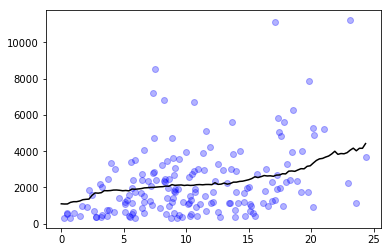

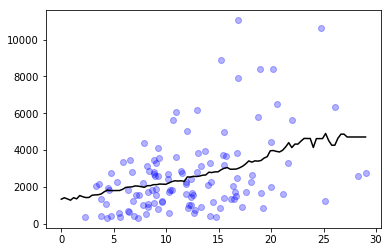

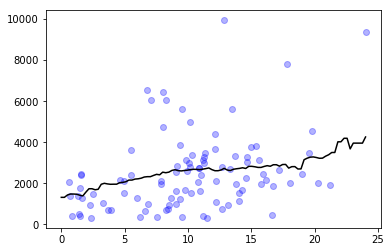

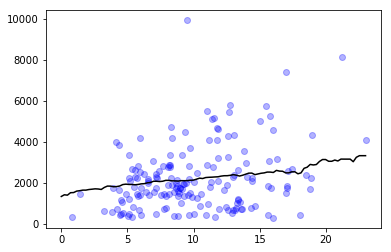

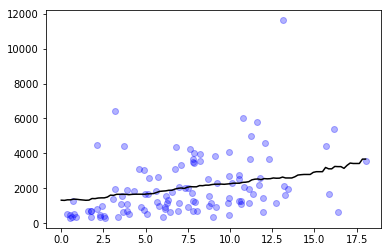

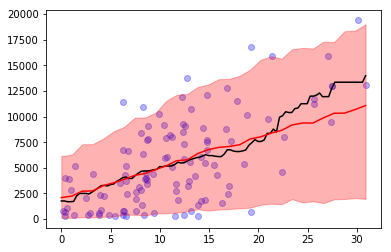

LiCl_64.0_R_L
PYY_1.5_R_L
Ex-4_0.3_A_D
PYY_7.5_R_L
Lep_2.0_A_D
LiCl_32.0_R_L
Error in LiCl_32.0_R_L_5_8_2014-11-03.B0105.CSV, IMI of 29468
saline_0.0_R_D


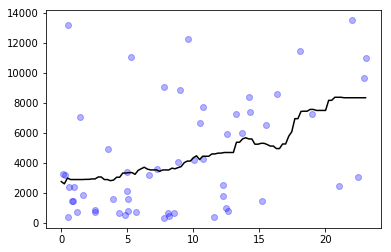

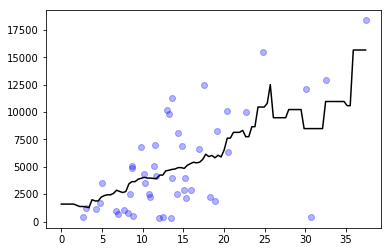

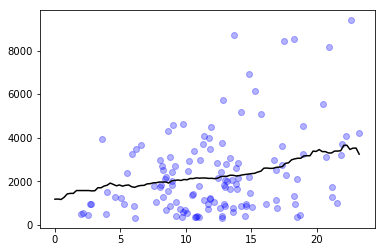

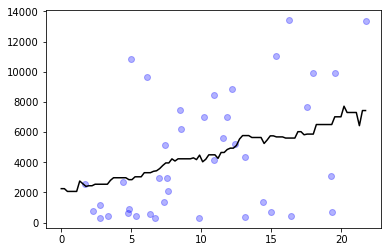

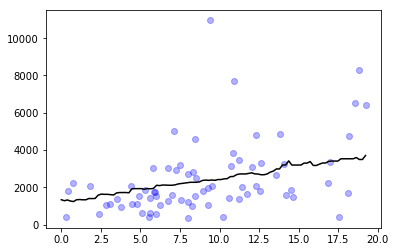

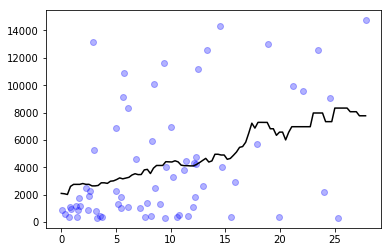

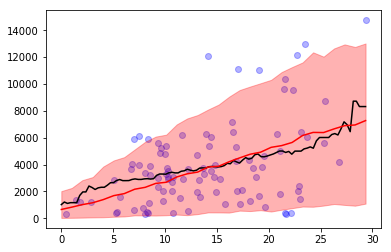

saline_0.0_A_D


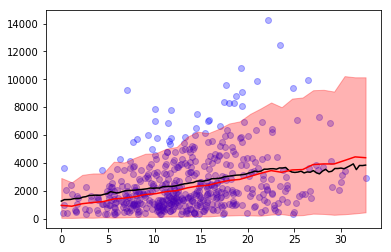

GLP-1_100.0_A_D
saline_0.0_A_L
Error in saline_0.0_A_L_11_10_2015-11-23.B0111.CSV, IMI of 20122
Error in saline_0.0_A_L_15_10_2015-11-23.B0115.CSV, IMI of 21444
Error in saline_0.0_A_L_15_10_2015-11-23.B0115.CSV, IMI of 21072


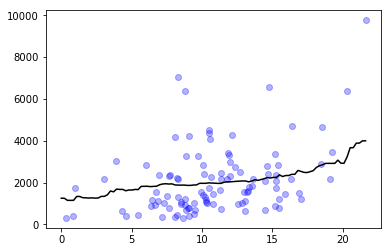

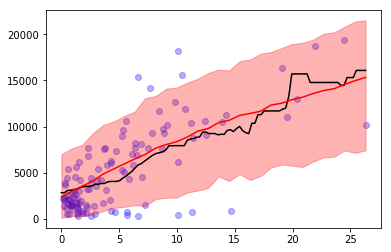

PYY_1.5_A_D
GLP-1_30.0_A_D
PYY_300.0_R_L


In [51]:
root_dir = 'new_all_data/'
cutoff = 300
num_samples = 1000
for i in os.listdir(root_dir):
    print i
    try:
        data_dir = root_dir + i + '/'
        plot_IMI(data_dir, group_dict, cutoff=cutoff, num_samples=num_samples)
    except KeyError:
        continue

In [ ]:
def plot_satiety_ratio(data_dir, cutoff=300):
    p_lengths = []
    mealsizes = []
    c = []
    windowsize = 5
    err_thresh = 20000

    ## Assemble dataset
    count = len(os.listdir(data_dir))
    for i, dataset in enumerate(os.listdir(data_dir)):
        data = np.loadtxt(data_dir+dataset, delimiter='\t', usecols=(0,1,2,3,4))

        mealsize = 0
        for j in data:
            
            f_length, g_start, rate, p_length, g_end = j
            mealsize += 3.5*rate*f_length
            
            if p_length > cutoff and p_length < err_thresh:
                p_lengths.append(p_length)
                mealsizes.append(mealsize)
                mealsize = 0
                c.append(float(i)/count)

            if p_length > err_thresh:
                print 'Error in %s, IMI of %3.0f' %(dataset, p_length)
                
    ## Process to use in moving window
    results = zip(mealsizes, p_lengths)
    results = np.array(results)

    ## Generate moving window mean
    x_grid = np.linspace(0, 30, 50)

    means = []
    for xval in x_grid:
        usevals = np.abs(results[:,0] - xval) < windowsize
        meanval = np.mean(results[usevals, 1])
        means.append(meanval)
        
    means = np.array(means)

    ## Plot moving window
    fig, axes = plt.subplots(1)
    axes.scatter(results[:,0], 
                 results[:,1], 
                 alpha=1.0, 
                 c=c, 
                 cmap=cm.gist_ncar)
    
    axes.plot(x_grid, means, c='k')
    
    ## Calculate satiety ratio
    """
    srs = []
    for i in results:
        ratio = float(i[1])/i[0]
        print ratio
        srs.append(ratio)
    satiety_ratio = np.mean(srs)
    """
    #satiety_ratio = np.mean(results, axis=0)[1]/np.mean(results, axis=0)[0]
    satiety_ratio = float(results[0][1])/results[0][0]
    
    ratio_predict = x_grid*satiety_ratio
    axes.plot(x_grid, ratio_predict, c='r')
    
    plt.show()

In [ ]:
root_dir = 'new_all_data/'
cutoff = 600
num_samples = 100
for i in os.listdir(root_dir):
    print i
    data_dir = root_dir + i + '/'
    plot_satiety_ratio(data_dir, cutoff=cutoff)